# 3 - Statistical Inference

#### Importing required modules

In [1]:
import os
import sys
from pathlib import Path

sys.path.append(str(Path(os.getcwd()).parent.absolute()) + "\\app")

In [1]:
import pandas as pd
import config
import scipy.stats as stats 
import scikit_posthocs as sph
from functions import remove_outliers, check_normality, get_significance, two_group_default_comparison, marascuilo_procedure
from functions_visualization import plot_dunn_results
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
pd.set_option("display.max_columns", None)


#### Setting access to reach GCP bucket

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = config.GOOGLE_APPLICATION_CREDENTIALS

#### Loading data

In [3]:
application_train = pd.read_csv(f"{config.DATA_DIRECTORY}application_train.csv")

#### Statistical inference

I've created a function called two_group_default_comparison to facilitate hypothesis testing for comparing two groups and their binary outcomes (TARGET). This function utilizes the Chi-square test for independence to determine if there's a significant association between two categorical variables. If the resulting p-value is below our threshold (0.05), indicating a significant association, we proceed to compare the default proportions between the two groups. We then conduct a proportions Z-test with an adjusted p-value (0.025) to obtain a more confident assessment of which group tends to default more.

##### Assumptions of Chi-Square test:
Both variables are categorical. <br>
All observations are independent.<br>
Cells in the contingency table are mutually exclusive.<br>
Expected value of cells should be 5 or greater in at least 80% of cells

##### Assumptions of Proportions z-test assumptions:

Independent Samples: The samples must be independent of each other. This means that the outcome in one sample should not affect the outcome in the other sample. In the context of your dataset, this means that each individual's likelihood of defaulting on a loan is independent of the others'.

Random Sampling: The data should be collected through a process of random sampling. That is, each individual in the population has an equal chance of being included in the sample.

Sample Size: Both groups being compared should be sufficiently large. A common rule of thumb is that the sample size should be such that you expect at least 10 successes (defaults) and 10 failures (non-defaults) in each group. This is sometimes referred to as the npq rule, where n is the sample size, p is the probability of success, and q is the probability of failure (q = 1 - p).

Normal Distribution of the Sample Proportion: The sample proportion should be normally distributed. For a proportion, this generally means that np and n(1-p) should both be greater than or equal to 10, where n is the sample size and p is the proportion of interest.

#### Is there are any difference in default rate for people who own a car? Do people who own a car default less / more?

In [4]:
crosstab_own_car = pd.crosstab(application_train['FLAG_OWN_CAR'], application_train['TARGET'])
crosstab_own_car

TARGET,0,1
FLAG_OWN_CAR,,
N,185675,17249
Y,97011,7576


In [5]:
two_group_default_comparison(crosstab_own_car)

Chi-square test for independence:
- Null Hypothesis (H0): No association between FLAG_OWN_CAR and the likelihood of defaulting on a loan. The proportions of default are equal across groups.
- Alternative Hypothesis (Ha): An association between FLAG_OWN_CAR and the likelihood of defaulting on a loan. The proportions of default differ between groups.

Chi-square Results: 
- Statistic: 146.66 
- P-value: 0.0 
- Degrees of freedom: 1
P value is below alpha 0.05 --> Rejecting H0.

Proportions Analysis:
- Default rate for FLAG_OWN_CAR = N: 0.085
- Default rate for FLAG_OWN_CAR = Y: 0.0724

Proportions Z-test:
- Z-statistic: -12.12
- P-value: 0.0
P-value is below 0.025 -> Reject Null Hypothesis.
Group N is more likely to default on a loan.


#### Is there are any difference in default rate for people who own real estate? Do people who own real estate default less / more?

In [6]:
crosstab_own_realty = pd.crosstab(application_train['FLAG_OWN_REALTY'], application_train['TARGET'])
crosstab_own_realty

TARGET,0,1
FLAG_OWN_REALTY,,
N,86357,7842
Y,196329,16983


In [7]:
two_group_default_comparison(crosstab_own_realty)

Chi-square test for independence:
- Null Hypothesis (H0): No association between FLAG_OWN_REALTY and the likelihood of defaulting on a loan. The proportions of default are equal across groups.
- Alternative Hypothesis (Ha): An association between FLAG_OWN_REALTY and the likelihood of defaulting on a loan. The proportions of default differ between groups.

Chi-square Results: 
- Statistic: 11.58 
- P-value: 0.001 
- Degrees of freedom: 1
P value is below alpha 0.05 --> Rejecting H0.

Proportions Analysis:
- Default rate for FLAG_OWN_REALTY = N: 0.0832
- Default rate for FLAG_OWN_REALTY = Y: 0.0796

Proportions Z-test:
- Z-statistic: -3.41
- P-value: 0.001
P-value is below 0.025 -> Reject Null Hypothesis.
Group N is more likely to default on a loan.


#### Is there are any difference in default rate for people below and above age 60? Do people over 60 default less / more?



In [8]:
application_train["AGE_YEARS"] = round(application_train["DAYS_BIRTH"]/-365)
application_train["AGE_GROUP"] = (application_train["AGE_YEARS"] >= 60).astype(int)
crosstab_age_60 = pd.crosstab(application_train["AGE_GROUP"], application_train["TARGET"])
crosstab_age_60

TARGET,0,1
AGE_GROUP,,
0,245599,22892
1,37087,1933


In [9]:
two_group_default_comparison(crosstab_age_60)

Chi-square test for independence:
- Null Hypothesis (H0): No association between AGE_GROUP and the likelihood of defaulting on a loan. The proportions of default are equal across groups.
- Alternative Hypothesis (Ha): An association between AGE_GROUP and the likelihood of defaulting on a loan. The proportions of default differ between groups.

Chi-square Results: 
- Statistic: 585.36 
- P-value: 0.0 
- Degrees of freedom: 1
P value is below alpha 0.05 --> Rejecting H0.

Proportions Analysis:
- Default rate for AGE_GROUP = 0: 0.0853
- Default rate for AGE_GROUP = 1: 0.0495

Proportions Z-test:
- Z-statistic: -24.2
- P-value: 0.0
P-value is below 0.025 -> Reject Null Hypothesis.
Group 0 is more likely to default on a loan.


#### Any statistical significance that some exact day applications tend to default more? 

- H0: The day of the week an application is submitted is independent of the likelihood of defaulting. There is no statistically significant association between the day of the week and default rates.
- Ha: The day of the week an application is submitted is not independent of the likelihood of defaulting. There is a statistically significant association between the day of the week and default rates.

In [10]:
crosstab_weekday = pd.crosstab(application_train["WEEKDAY_APPR_PROCESS_START"], application_train["TARGET"])
crosstab_weekday

TARGET,0,1
WEEKDAY_APPR_PROCESS_START,,
FRIDAY,46237,4101
MONDAY,46780,3934
SATURDAY,31182,2670
SUNDAY,14898,1283
THURSDAY,46493,4098
TUESDAY,49400,4501
WEDNESDAY,47696,4238


In [11]:
chi_stat, p_chi_weekday, dof, expected = chi2_contingency(crosstab_weekday)
get_significance(p_chi_weekday)

'P value is below alpha 0.05 --> Reject H0.'

There is a significant difference in at least one group of application days. In order to get know between which exact groups there are significant association, we will use The Marascuilo proceduro. Reference:https://www.itl.nist.gov/div898/handbook/prc/section4/prc474.htm
It requires calculating the chi-square statistic for each pair of categories and comparing it to a critical value that takes into account the number of comparisons. I have created a marascuilo_procedure function, which can be found in functions.py

In [12]:
marascuilo_procedure(crosstab_weekday, 1, alpha=0.05, adjust_method='bonferroni')

,Category1,Category2,Difference,Proportion1,Proportion2,Critical Value,P-Value,Adjusted P-Value
9,MONDAY,TUESDAY,0.005933,0.077572,0.083505,0.006399,0.000422,0.008856


It appears that applications submitted on Tuesday have a higher tendency to default compared to those submitted on Monday. However, there are no significant differences observed in default rates for other comparisons.

#### Any statistical significance that some exact hour applications tend to default more?

In [13]:
crosstab_hour = pd.crosstab(application_train["HOUR_APPR_PROCESS_START"], application_train["TARGET"])
crosstab_hour

TARGET,0,1
HOUR_APPR_PROCESS_START,,
0,34,6
1,79,7
2,275,30
3,1123,107
4,1917,173
5,3253,385
6,5197,645
7,8214,917
8,13754,1373


In [14]:
chi_stat, p_chi_hour, dof, expected = chi2_contingency(crosstab_hour)
get_significance(p_chi_hour)

'P value is below alpha 0.05 --> Reject H0.'

In [15]:
marascuilo_procedure(crosstab_hour, 1, alpha=0.05)

,Category1,Category2,Difference,Proportion1,Proportion2,Critical Value,P-Value,Adjusted P-Value
87,4,6,0.027632,0.082775,0.110407,0.010695,1.502800e-04,4.147727e-02
108,5,9,0.023772,0.105827,0.082055,0.010695,9.308646e-06,2.569186e-03
109,5,10,0.025609,0.105827,0.080218,0.010695,1.282206e-06,3.538888e-04
110,5,11,0.025084,0.105827,0.080744,0.010695,2.137089e-06,5.898367e-04
111,5,12,0.023246,0.105827,0.082581,0.010695,1.210701e-05,3.341534e-03
112,5,13,0.025560,0.105827,0.080267,0.010695,1.613743e-06,4.453930e-04
113,5,14,0.026751,0.105827,0.079077,0.010695,5.779034e-07,1.595013e-04
114,5,15,0.029898,0.105827,0.075929,0.010695,2.579978e-08,7.120739e-06
115,5,16,0.031214,0.105827,0.074614,0.010695,8.569415e-09,2.365159e-06
116,5,17,0.040928,0.105827,0.064899,0.010695,8.526513e-14,2.353318e-11


We have received many statistical significant differences between various hours. Applications filled on 6:00 has the highest proportions of default rates and had the most significant difference when compared to applications filed at the evening on 17:00 - 21:00.

#### Does people with a higher education would default less? <br>

In [16]:
crosstab_education = pd.crosstab(application_train["NAME_EDUCATION_TYPE"], application_train["TARGET"])
crosstab_education

TARGET,0,1
NAME_EDUCATION_TYPE,,
Academic degree,161,3
Higher education,70854,4009
Incomplete higher,9405,872
Lower secondary,3399,417
Secondary / secondary special,198867,19524


Education type "Acadmeic degree" is really under represented, therefore I will drop it, and conduct the tests without it.

In [17]:
crosstab_education.drop('Academic degree', inplace=True)

Hypotheses:

- H0: There is no association between the level of education and the likelihood of defaulting on a loan. The proportion of loan defaults (TARGET=1) is the same across all education levels.<br>
- Ha: There is an association between the level of education and the likelihood of defaulting on a loan. The proportion of loan defaults (TARGET=1) varies significantly across different education levels.

In [18]:
chi_stat, p_chi_education, dof, expected = chi2_contingency(crosstab_education)
get_significance(p_chi_education)

'P value is below alpha 0.05 --> Reject H0.'

In [19]:
marascuilo_procedure(crosstab_education, 1, alpha=0.05)

,Category1,Category2,Difference,Proportion1,Proportion2,Critical Value,P-Value,Adjusted P-Value
0,Higher education,Incomplete higher,0.031299,0.053551,0.084850,0.005042,0.000000,0.000000
1,Higher education,Lower secondary,0.055726,0.053551,0.109277,0.005042,0.000000,0.000000
2,Higher education,Secondary / secondary special,0.035848,0.053551,0.089399,0.005042,0.000000,0.000000
3,Incomplete higher,Lower secondary,0.024427,0.084850,0.109277,0.005042,0.000022,0.000129
5,Lower secondary,Secondary / secondary special,0.019877,0.109277,0.089399,0.005042,0.000093,0.000560


We can see that people with higher education have the lowest default rate. People with secondary or incomplete higher education have a statistically significant difference in default rate when compared to people who have a higher education degree. We can confirm, that people with a higher education are defaulting less.

#### Are there are any difference in clients default rate, when where they lives? 

In [20]:
crosstab_place = pd.crosstab(application_train["REGION_RATING_CLIENT_W_CITY"], application_train["TARGET"])
crosstab_place

TARGET,0,1
REGION_RATING_CLIENT_W_CITY,,
1,32513,1654
2,211314,18170
3,38859,5001


- H0: There is no association between the rating of a client's region with city and the likelihood of defaulting on a loan. The proportion of loan defaults (TARGET=1) is the same across all ratings of region/city levels.

- Ha: There is an association between the rating of a client's region with city and the likelihood of defaulting on a loan. The proportion of loan defaults (TARGET=1) varies across different ratings of region/city levels.

In [21]:
chi_stat, p_chi_place, dof, expected = chi2_contingency(crosstab_place)
get_significance(p_chi_place)

'P value is below alpha 0.05 --> Reject H0.'

In [22]:
marascuilo_procedure(crosstab_place, 1, alpha=0.05)

,Category1,Category2,Difference,Proportion1,Proportion2,Critical Value,P-Value,Adjusted P-Value
0,1,2,0.030768,0.048409,0.079178,0.004414,0.0,0.0
1,1,3,0.065613,0.048409,0.114022,0.004414,0.0,0.0
2,2,3,0.034844,0.079178,0.114022,0.004414,0.0,0.0


We do see a statistically significant difference while comparing all available groups. As could have been expected, people who lives in regions/cities with rating 1, has the least default rate. People with rating of 3 - a highest default rate.

#### Are there are any difference in clients income, when comparing the rating of their region? 

In [23]:
application_train = remove_outliers(application_train, "AMT_INCOME_TOTAL")

Old Shape:  (307511, 124)
New Shape:  (293476, 124)
Values dropped: 14035


In [24]:
ratings = sorted(application_train["REGION_RATING_CLIENT_W_CITY"].unique())
income_by_place_rate = {}
for rating in ratings:
    income_by_place_rate[rating] = application_train[application_train["REGION_RATING_CLIENT_W_CITY"] == rating]["AMT_INCOME_TOTAL"]
    
for rating, data in income_by_place_rate.items():
    print(f"Income of rating {rating}:")
    check_normality(data)

Income of rating 1:
Skewness coef.: 0.13
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Income of rating 2:
Skewness coef.: 0.69
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Income of rating 3:
Skewness coef.: 0.82
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 



Hypotheses:

- H0: There is no association between the rating of a client's region with city and client income. This implies that the level of income is the same across all ratings of region/city levels.

- Ha: There is an association between the rating of a client's region with city and client income. This implies that the level of income varies across different ratings of region/city levels.

In [25]:
model = stats.kruskal(*income_by_place_rate.values())
get_significance(model.pvalue)

'P value is below alpha 0.05 --> Reject H0.'

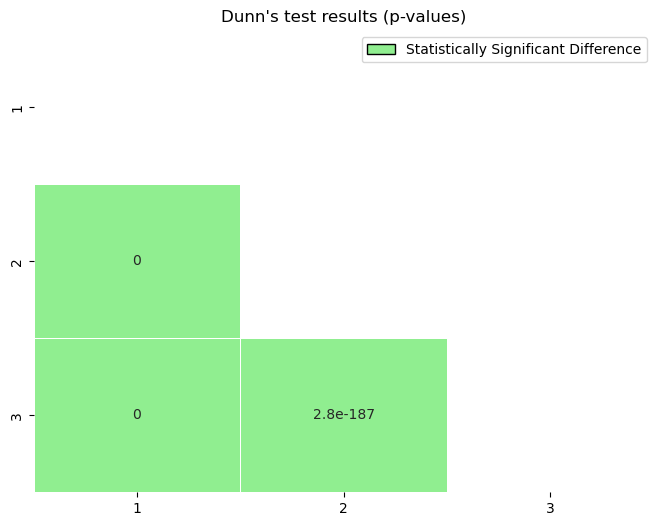

In [26]:
dunn_test_inc = sph.posthoc_dunn(list(income_by_place_rate.values()))
dunn_test_inc.columns = list(income_by_place_rate.keys())
dunn_test_inc.index = list(income_by_place_rate.keys())

plot_dunn_results(dunn_test_inc, 0.05)

Null hypothesis is rejected when comparing all available groups. the level of income varies across different ratings of region/city levels.

#### Are there are any difference in clients credit amount, when comparing the rating of their region? 

In [27]:
application_train = remove_outliers(application_train, "AMT_CREDIT")

Old Shape:  (293476, 124)
New Shape:  (287724, 124)
Values dropped: 5752


In [28]:
ratings = sorted(application_train["REGION_RATING_CLIENT_W_CITY"].unique())
credit_by_place_rate = {}
for rating in ratings:
    credit_by_place_rate[rating] = application_train[application_train["REGION_RATING_CLIENT_W_CITY"] == rating]["AMT_CREDIT"]
    
for rating, data in credit_by_place_rate.items():
    print(f"Income of rating {rating}:")
    check_normality(data)

Income of rating 1:
Skewness coef.: 0.61
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Income of rating 2:
Skewness coef.: 0.81
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Income of rating 3:
Skewness coef.: 0.84
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 



#### Hypotheses

- H0: There is no difference in the average credit amount among clients from different region ratings. In other words, the mean credit amount is the same across all region ratings.

- Ha: There is a difference in the average credit amount among clients from different region ratings. This means that at least one region rating group has a mean credit amount that differs from the others.

In [29]:
model = stats.kruskal(*credit_by_place_rate.values())
get_significance(model.pvalue)

'P value is below alpha 0.05 --> Reject H0.'

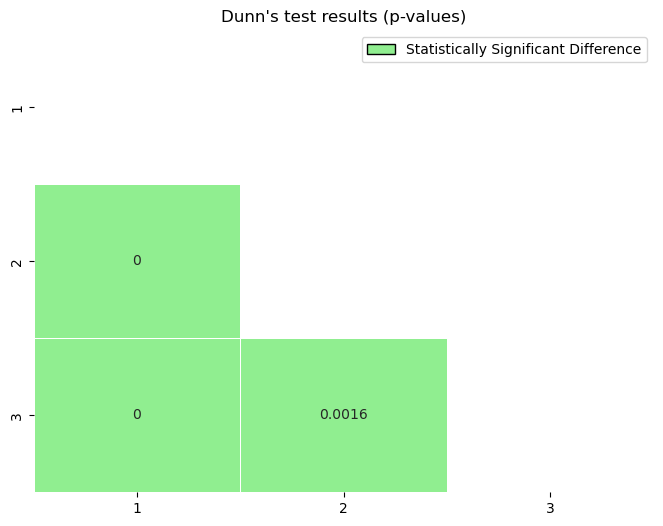

In [30]:
dunn_test_inc = sph.posthoc_dunn(list(credit_by_place_rate.values()))
dunn_test_inc.columns = list(credit_by_place_rate.keys())
dunn_test_inc.index = list(credit_by_place_rate.keys())

plot_dunn_results(dunn_test_inc, 0.05)

Null Hypothesis is rejected in all possible group comparisons. There is a significant difference in the average credit amount among clients from different region ratings.

#### Are there are any difference in clients credit amount, when comparing the housing type?

In [31]:
application_train = application_train.dropna(subset=["NAME_HOUSING_TYPE"])

In [32]:
types = application_train["NAME_HOUSING_TYPE"].unique()
credit_by_occupation = {}
for rating in types:
    credit_by_occupation[rating] = application_train[application_train["NAME_HOUSING_TYPE"] == rating]["AMT_CREDIT"]

#### Hypotheses

- H0 There is no difference in the average credit amount across different housing types. The mean credit amount for clients is the same regardless of the housing type they live in.

- Ha: There is a difference in the average credit amount across different housing types. At least one housing type group's mean credit amount is different from others.

In [33]:
model = stats.kruskal(*credit_by_occupation.values())
get_significance(model.pvalue)

'P value is below alpha 0.05 --> Reject H0.'

In [34]:
types = application_train["NAME_HOUSING_TYPE"].unique()
credit_by_occupation = {}
for rating in types:
    credit_by_occupation[rating] = application_train[application_train["NAME_HOUSING_TYPE"] == rating]["AMT_CREDIT"]
    
for rating, data in credit_by_occupation.items():
    print(f"Income of rating {rating}:")
    check_normality(data)

Income of rating House / apartment:
Skewness coef.: 0.78
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Income of rating Rented apartment:
Skewness coef.: 1.00
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Income of rating With parents:
Skewness coef.: 1.08
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Income of rating Municipal apartment:
Skewness coef.: 0.79
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Income of rating Office apartment:
Skewness coef.: 0.74
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Income of rating Co-op apartment:
Skewness coef.: 0.86
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 



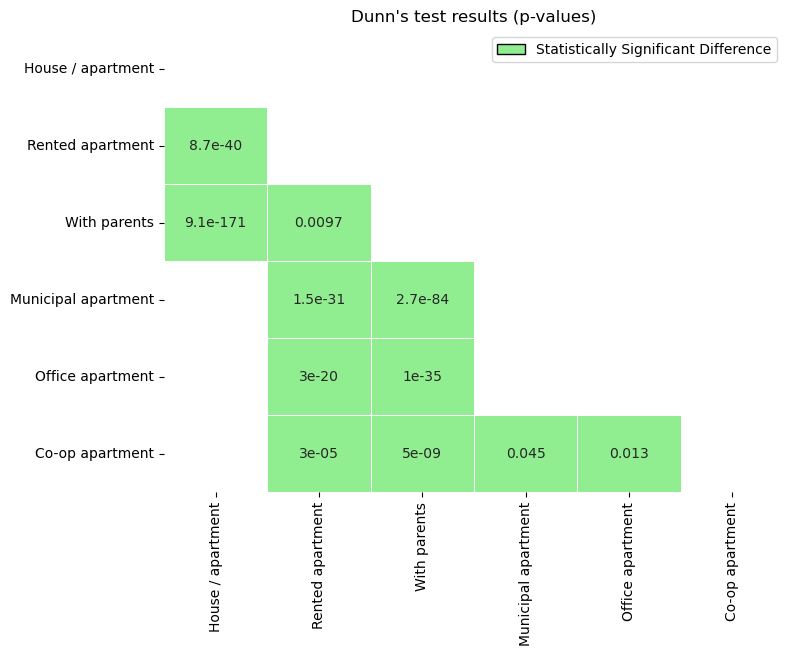

In [35]:
dunn_test_c = sph.posthoc_dunn(list(credit_by_occupation.values()))
dunn_test_c.columns = list(credit_by_occupation.keys())
dunn_test_c.index = list(credit_by_occupation.keys())

plot_dunn_results(dunn_test_c, 0.05)

We can see statistically significant difference in creadit amount across all types of apartments, except when comparing House/apartment to Municipal and Office apartments.

In [36]:
application_train.isna().sum(axis=1).describe()

count    287724.000000
mean         30.211407
std          20.862883
min           0.000000
25%           6.000000
50%          41.000000
75%          49.000000
max          61.000000
dtype: float64

#### Are people with incomplete application defaults more often?

In [37]:
application_train["INCOMPLETE"] = (application_train.isna().sum(axis=1)>35).astype(int)

In [38]:
crosstab_incomplete = pd.crosstab(application_train["INCOMPLETE"], application_train["TARGET"])
crosstab_incomplete

TARGET,0,1
INCOMPLETE,,
0,130619,10045
1,133343,13717


#### Hypotheses

- H0: The proportion of defaults (TARGET=1) is the same between people with complete applications (including housing information) and those with incomplete applications (missing housing information).

- Ha: The proportion of defaults (TARGET=1) differs between people with complete applications (including housing information) and those with incomplete applications (missing housing information).

In [39]:
two_group_default_comparison(crosstab_incomplete)

Chi-square test for independence:
- Null Hypothesis (H0): No association between INCOMPLETE and the likelihood of defaulting on a loan. The proportions of default are equal across groups.
- Alternative Hypothesis (Ha): An association between INCOMPLETE and the likelihood of defaulting on a loan. The proportions of default differ between groups.

Chi-square Results: 
- Statistic: 453.31 
- P-value: 0.0 
- Degrees of freedom: 1
P value is below alpha 0.05 --> Rejecting H0.

Proportions Analysis:
- Default rate for INCOMPLETE = 0: 0.0714
- Default rate for INCOMPLETE = 1: 0.0933

Proportions Z-test:
- Z-statistic: 21.3
- P-value: 0.0
P-value is below 0.025 -> Reject Null Hypothesis.
Group 1 is more likely to default on a loan.


### Statistically significant findings

Who default less?

People who own car or real estate.<br>
People with age over 60.<br>
People filled applications on Tuesday when compared to Monday filled applications.<br>
Applications filled on 6:00 has the highest proportions of default rates, and 17:00-21:00 lowest.<br>
People with higher education.<br>
People who live in lower rated regions/cities. We can also see difference in their income too.<br>
People with fully filled infromation defaults less.<br>


We do see a significant difference between amount of credit between all region ratings and all housing types (except when comparing House/apartment to Municipal and Office apartments.)
